First we import all packages and libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
import duckdb

Then we do some data exploration on one of the trianing files to see what needs to happen to clean and preprocess the data

In [2]:
def preprocess_imdb_data(data_path, directors_path, writers_path):
    """
    General preprocessing pipeline for IMDB data.

    Arguments:
    - data_path: Path to the train/test/validation data CSV file.
    - directors_path: Path to the directing.json file.
    - writers_path: Path to the writing.json file.

    Returns:
    - Cleaned Pandas DataFrame ready for model training or prediction.
    """

    # Step 1: Load main dataset
    df = pd.read_csv(data_path)

    # Step 2: Load JSON files (Directors & Writers)
    df_directors = pd.read_json(directors_path)
    df_writers = pd.read_json(writers_path)

    # Step 3: Rename columns for consistency
    df_directors.rename(columns={"movie": "tconst", "director": "director_id"}, inplace=True)
    df_writers.rename(columns={"movie": "tconst", "writer": "writer_id"}, inplace=True)

    # Step 4: Convert nested JSON fields into strings (fixes 'unhashable type' error)
    df_directors["director_id"] = df_directors["director_id"].astype(str)
    df_writers["writer_id"] = df_writers["writer_id"].astype(str)

    # Step 5: Merge main dataset with Directors & Writers using DuckDB
    con = duckdb.connect()
    con.register("movies", df)
    con.register("directors", df_directors)
    con.register("writers", df_writers)

    query = """
    SELECT
        movies.*,
        directors.director_id,
        writers.writer_id
    FROM movies
    LEFT JOIN directors ON movies.tconst = directors.tconst
    LEFT JOIN writers ON movies.tconst = writers.tconst
    """

    df = con.execute(query).fetchdf()
    con.close()

    # Step 6: Drop unnecessary columns
    columns_to_drop = ["originalTitle", "endYear", "Unnamed: 0"]
    df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

    # Step 7: Handle missing values
    numeric_columns = ["startYear", "runtimeMinutes", "numVotes"]
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors="coerce")  # Ensure numeric format
    df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())  # Fill missing with median

    df["director_id"] = df["director_id"].fillna("unknown")
    df["writer_id"] = df["writer_id"].fillna("unknown")

    # Step 8: Ensure correct data types
    df["startYear"] = df["startYear"].astype(int)
    df["runtimeMinutes"] = df["runtimeMinutes"].astype(int)
    df["numVotes"] = df["numVotes"].astype(int)

    # Step 9: Ensure each tconst is unique
    df = df.groupby("tconst").first().reset_index()

    return df

In [3]:
# Define file paths
train_files = [
    "../imdb/train-1.csv",
    "../imdb/train-2.csv",
    "../imdb/train-3.csv",
    "../imdb/train-4.csv",
    "../imdb/train-5.csv",
    "../imdb/train-6.csv",
    "../imdb/train-7.csv",
    "../imdb/train-8.csv"
]

directors_path = "../imdb/directing.json"
writers_path = "../imdb/writing.json"

# Preprocess and merge all training data
df_train = pd.concat([preprocess_imdb_data(file, directors_path, writers_path) for file in train_files], ignore_index=True)

# Preprocess validation and test data
df_val = preprocess_imdb_data("../imdb/validation_hidden.csv", directors_path, writers_path)
df_test = preprocess_imdb_data("../imdb/test_hidden.csv", directors_path, writers_path)

# Save cleaned datasets
# df_train.to_csv("final_training_data.csv", index=False)
# df_val.to_csv("final_validation_data.csv", index=False)
# df_test.to_csv("final_test_data.csv", index=False)

print("\n✅ All datasets have been preprocessed and saved!")



✅ All datasets have been preprocessed and saved!


In [4]:
df_train.head()

,tconst,primaryTitle,startYear,runtimeMinutes,numVotes,label,director_id,writer_id
0,tt0010600,The Doll,1919,66,1898,True,nm0523932,nm0932559
1,tt0011841,Way Down East,1920,145,5376,True,nm0000428,nm0000428
2,tt0012494,Déstiny,1921,97,5842,True,nm0000485,nm0902376
3,tt0015163,The Navigator,1924,59,9652,True,nm0187981,nm0369841
4,tt0016220,The Phantom of the Opera,1925,93,17887,True,nm0432216,nm1541473


In [5]:
df_train.dtypes

tconst            object
primaryTitle      object
startYear          int64
runtimeMinutes     int64
numVotes           int64
label               bool
director_id       object
writer_id         object
dtype: object

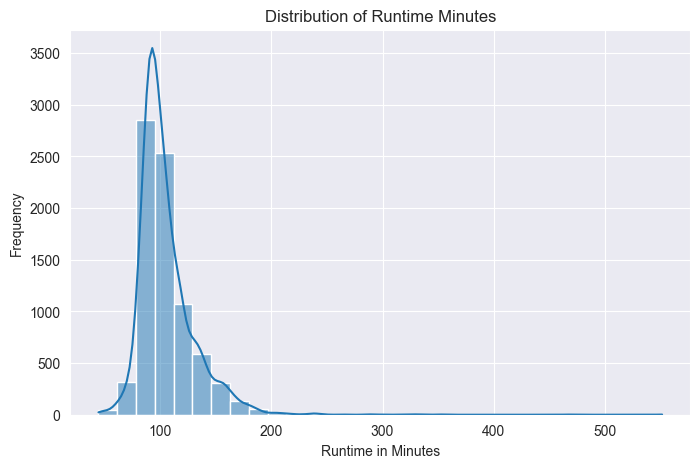

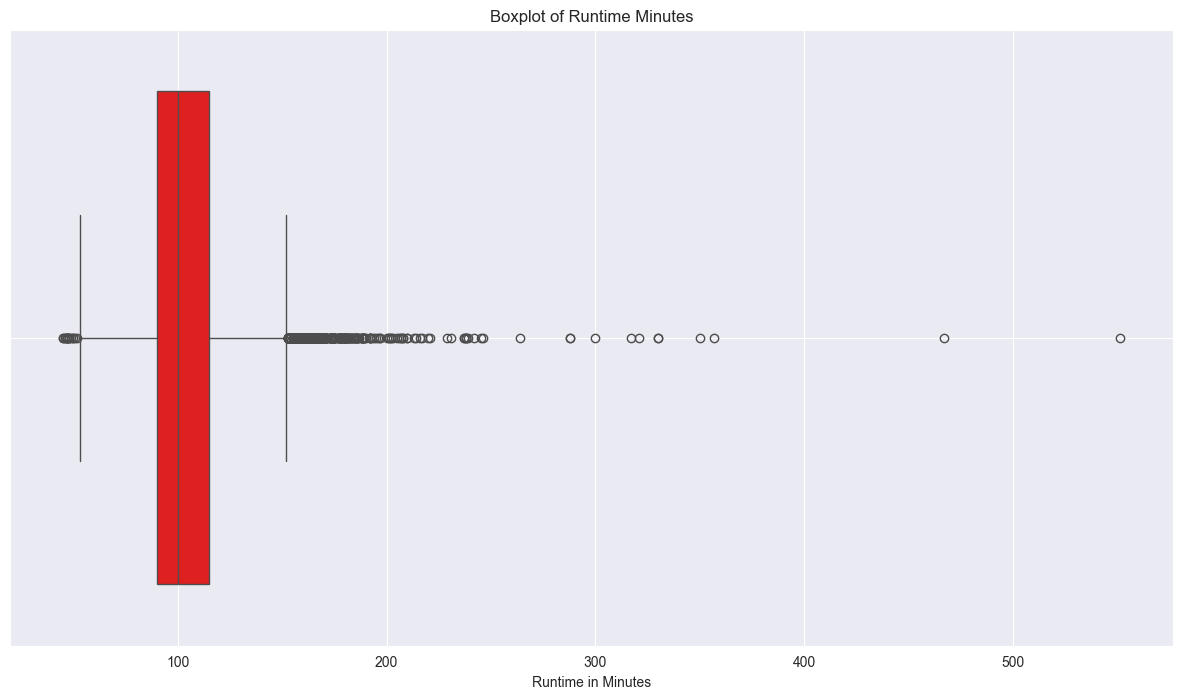

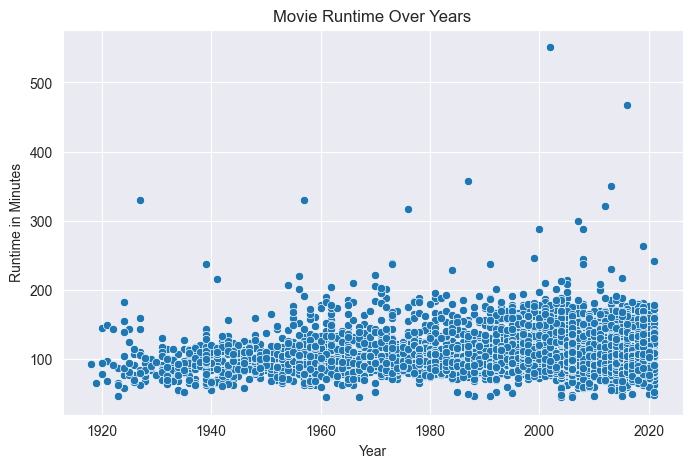

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the dataset in a DataFrame called df
# Load your dataset: df = pd.read_csv("your_file.csv")

# Histogram
plt.figure(figsize=(8, 5))
sns.histplot(df_train['runtimeMinutes'], bins=30, kde=True)
plt.xlabel('Runtime in Minutes')
plt.ylabel('Frequency')
plt.title('Distribution of Runtime Minutes')
plt.gca().grid(True)  # Force gridlines to appear
plt.show()

# Boxplot
plt.figure(figsize=(15, 8))
sns.boxplot(x=df_train['runtimeMinutes'], color='red')
plt.xlabel('Runtime in Minutes')
plt.title('Boxplot of Runtime Minutes')
plt.gca().grid(True)  # Force gridlines to appear
plt.show()

# Scatter Plot (Runtime vs Year)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_train['startYear'], y=df_train['runtimeMinutes'])
plt.xlabel('Year')
plt.ylabel('Runtime in Minutes')
plt.title('Movie Runtime Over Years')
plt.gca().grid(True)  # Force gridlines to appear
plt.show()


In [7]:
def preprocess_runtime(df, k=0.1):
    """
    Preprocesses the runtime information, including handling extreme values
    (movies with runtime > 1000 minutes, possibly in seconds or hours).

    Arguments:
    - df: DataFrame containing the movie data.
    - k: Proportion of values to trim from each end when computing the trimmed mean.

    Returns:
    - DataFrame with cleaned runtime information.
    """

    # Handle movies that are possibly in seconds or hours
    df["runtimeMinutes"] = df["runtimeMinutes"].apply(lambda x: x / 60 if x > 1000 else x)  # Convert seconds to minutes
    df["runtimeMinutes"] = df["runtimeMinutes"].apply(lambda x: x * 60 if x < 5 else x)  # Convert minutes to hours if under 5 mins

    # Compute k-trimmed mean for runtimeMinutes (ignoring NaN values)
    trimmed_mean_runtime = trim_mean(df["runtimeMinutes"].dropna(), proportiontocut=k)

    print(trimmed_mean_runtime)

    # Fill missing values with trimmed mean
    df["runtimeMinutes"].fillna(trimmed_mean_runtime)

    return df

In [8]:
def handle_missing_values_and_convert(df):
    """
    Handles missing values, drops unnecessary columns, and converts columns to the appropriate data types.

    Arguments:
    - df: DataFrame to clean and process.

    Returns:
    - DataFrame with missing values handled and relevant columns converted.
    """
    # Step 1: Drop 'originalTitle' column (if required)
    df.drop(columns=["originalTitle"], inplace=True, errors="ignore")

    # Step 2: Convert relevant columns to integers, handling errors
    cols_to_convert = ["startYear", "endYear", "runtimeMinutes"]
    for col in cols_to_convert:
        df[col] = pd.to_numeric(df[col], errors="coerce").astype("Int64")  # Keeps NaNs as <NA>

    # Step 3: Check for missing values
    print("Missing values per column before imputation:")
    print(df.isnull().sum())

    # Step 4: Calculate the average difference between startYear and endYear
    valid_years = df.dropna(subset=["startYear", "endYear"])  # Keep only complete cases
    avg_duration = (valid_years["endYear"] - valid_years["startYear"]).mean()

    # Step 5: Fill missing endYear values by adding the average duration to startYear
    df.loc[df["endYear"].isna(), "endYear"] = df["startYear"] + avg_duration
    df["endYear"] = df["endYear"].round().astype("Int64")  # Convert to integer

    # Step 6: Handle other missing values
    df["startYear"] = df["startYear"].fillna(df["startYear"].median())
    df["runtimeMinutes"] = df["runtimeMinutes"].fillna(df["runtimeMinutes"].median())
    df["numVotes"] = df["numVotes"].fillna(0)

    # Step 7: Display cleaned data
    print("Missing values per column after imputation:")
    print(df.isnull().sum())

    return df

In [9]:
import pandas as pd
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import trim_mean

def preprocess_clean(data_path, directors_path, writers_path, k=0.1):
    """
    General preprocessing pipeline for IMDB data.

    Arguments:
    - data_path: Path to the train/test/validation data CSV file.
    - directors_path: Path to the directing.json file.
    - writers_path: Path to the writing.json file.
    - k: Proportion of values to trim from each end when computing the trimmed mean.

    Returns:
    - Cleaned Pandas DataFrame with missing values filled appropriately.
    """

    # Step 1: Load main dataset
    df = pd.read_csv(data_path)

    # Step 2: Load JSON files (Directors & Writers)
    df_directors = pd.read_json(directors_path)
    df_writers = pd.read_json(writers_path)

    # Step 3: Rename columns for consistency
    df_directors.rename(columns={"movie": "tconst", "director": "director_id"}, inplace=True)
    df_writers.rename(columns={"movie": "tconst", "writer": "writer_id"}, inplace=True)

    # Step 4: Convert nested JSON fields into strings
    df_directors["director_id"] = df_directors["director_id"].astype(str)
    df_writers["writer_id"] = df_writers["writer_id"].astype(str)

    # Step 5: Merge main dataset with Directors & Writers using DuckDB
    con = duckdb.connect()
    con.register("movies", df)
    con.register("directors", df_directors)
    con.register("writers", df_writers)

    query = """
    SELECT
        movies.*,
        directors.director_id,
        writers.writer_id
    FROM movies
    LEFT JOIN directors ON movies.tconst = directors.tconst
    LEFT JOIN writers ON movies.tconst = writers.tconst
    """

    df = con.execute(query).fetchdf()
    con.close()

    # Step 6: Handle missing values and convert columns
    df = handle_missing_values_and_convert(df)

    # Step 7: Preprocess and clean runtimeMinutes
    df = preprocess_runtime(df, k)

    # Step 8: Ensure each `tconst` is unique
    df = df.groupby("tconst").first().reset_index()

    return df


In [10]:
def print_cleaned_df_info(df):
    """
    Prints general information about the cleaned DataFrame:
    - First few rows
    - Null values per column
    - Data types
    - Descriptive statistics

    Arguments:
    - df: DataFrame to display information about.
    """
    # Print the first few rows of the cleaned dataframe
    print("First few rows of the cleaned DataFrame:")
    print(df.head())

    # Check for missing values
    print("\nMissing values per column:")
    print(df.isnull().sum())

    # Check the data types of each column
    print("\nData types of each column:")
    print(df.dtypes)

    # Get descriptive statistics for numerical columns
    print("\nDescriptive statistics for numerical columns:")
    print(df.describe())

In [11]:
# Define file paths
train_files = [
    "./imdb/train-1.csv",
    "./imdb/train-2.csv",
    "./imdb/train-3.csv",
    "./imdb/train-4.csv",
    "./imdb/train-5.csv",
    "./imdb/train-6.csv",
    "./imdb/train-7.csv",
    "./imdb/train-8.csv"
]

directors_path = "imdb/directing.json"
writers_path = "imdb/writing.json"

# Preprocess and merge all training data
df_train = pd.concat([preprocess_clean(file, directors_path, writers_path) for file in train_files], ignore_index=True)

# Preprocess validation and test data
df_val = preprocess_clean("imdb/validation_hidden.csv", directors_path, writers_path)
df_test = preprocess_clean("imdb/test_hidden.csv", directors_path, writers_path)

# Save cleaned datasets
df_train.to_csv("./cleaned/final_training_data.csv", index=False)
df_val.to_csv("./cleaned/final_validation_data.csv", index=False)
df_test.to_csv("./cleaned/final_test_data.csv", index=False)

print("\n✅ All datasets have been preprocessed and saved!")


FileNotFoundError: [Errno 2] No such file or directory: './imdb/train-1.csv'

In [12]:
# Print cleaned DataFrame info for train dataset
print_cleaned_df_info(df_train)

First few rows of the cleaned DataFrame:
      tconst  Unnamed: 0              primaryTitle  startYear  endYear  \
0  tt0010600           4                  The Doll       1919     <NA>   
1  tt0011841           7             Way Down East       1920     <NA>   
2  tt0012494           9                   Déstiny       1921     <NA>   
3  tt0015163          25             The Navigator       1924     <NA>   
4  tt0016220          38  The Phantom of the Opera       1925     <NA>   

   runtimeMinutes  numVotes  label director_id  writer_id  
0              66    1898.0   True   nm0523932  nm0932559  
1             145    5376.0   True   nm0000428  nm0000428  
2              97    5842.0   True   nm0000485  nm0902376  
3              59    9652.0   True   nm0187981  nm0369841  
4              93   17887.0   True   nm0432216  nm1541473  

Missing values per column:
tconst               0
Unnamed: 0           0
primaryTitle         0
startYear            0
endYear           7173
runtimeMinu

In [13]:
# Print cleaned DataFrame info for test dataset
print_cleaned_df_info(df_test)

First few rows of the cleaned DataFrame:
      tconst  Unnamed: 0                         primaryTitle  startYear  \
0  tt0014972          22                  He Who Gets Slapped       1924   
1  tt0015016          23                       The Iron Horse       1924   
2  tt0015174          26  Die Nibelungen: Kriemhild's Revenge       1924   
3  tt0015214          28                              At 3:25       2004   
4  tt0015863          34                              Go West       1925   

   endYear  runtimeMinutes  numVotes director_id  writer_id  
0     <NA>              95    3654.0   nm0803705  nm0014703  
1     <NA>             150    2136.0   nm0000406  nm0201544  
2     <NA>             129    4341.0   nm0000485  nm0902376  
3     1925              59    1724.0   nm0163229  nm0163229  
4     <NA>              69    4188.0   nm0000036  nm0134252  

Missing values per column:
tconst              0
Unnamed: 0          0
primaryTitle        0
startYear           0
endYear       

In [14]:
# Print cleaned DataFrame info for validation dataset
print_cleaned_df_info(df_val)

First few rows of the cleaned DataFrame:
      tconst  Unnamed: 0               primaryTitle  startYear  endYear  \
0  tt0003740           0                    Cabiria       1914     <NA>   
1  tt0008663           1            A Man There Was       1917     <NA>   
2  tt0010307           3                  J'accuse!       1919     <NA>   
3  tt0014429          18               Safety Last!       1923     <NA>   
4  tt0015175          27  Die Nibelungen: Siegfried       1924     <NA>   

   runtimeMinutes  numVotes director_id  writer_id  
0             148    3452.0   nm0665163  nm0758215  
1              65    1882.0   nm0803705  nm0803705  
2             166    1692.0   nm0304098  nm0304098  
3              74   19898.0   nm0628345  nm0516001  
4             143    5676.0   nm0000485  nm0902376  

Missing values per column:
tconst              0
Unnamed: 0          0
primaryTitle        0
startYear           0
endYear           861
runtimeMinutes      0
numVotes            0
director

In [15]:
def calculate_unique_ratio(df, columns=None):
    """
    Calculate the ratio of unique rows to total rows in the DataFrame.

    Arguments:
    - df: DataFrame to analyze
    - columns: List of columns to consider (if None, uses all columns)

    Returns:
    - Dictionary containing unique ratio metrics
    """
    if columns is None:
        columns = df.columns

    total_rows = len(df)
    unique_rows = len(df[columns].drop_duplicates())
    ratio = unique_rows / total_rows

    metrics = {
        "total_rows": total_rows,
        "unique_rows": unique_rows,
        "unique_ratio": ratio
    }

    return metrics

# Add this after your data preprocessing
print("\n🔍 Analyzing unique row ratios...")

# Calculate ratios for all datasets
train_metrics = calculate_unique_ratio(df_train)
val_metrics = calculate_unique_ratio(df_val)
test_metrics = calculate_unique_ratio(df_test)

# Print results
print("\nUnique Row Analysis:")
print(f"Training Data:")
print(f"  - Total Rows: {train_metrics['total_rows']:,}")
print(f"  - Unique Rows: {train_metrics['unique_rows']:,}")
print(f"  - Unique Ratio: {train_metrics['unique_ratio']:.2%}")

print(f"\nValidation Data:")
print(f"  - Total Rows: {val_metrics['total_rows']:,}")
print(f"  - Unique Rows: {val_metrics['unique_rows']:,}")
print(f"  - Unique Ratio: {val_metrics['unique_ratio']:.2%}")

print(f"\nTest Data:")
print(f"  - Total Rows: {test_metrics['total_rows']:,}")
print(f"  - Unique Rows: {test_metrics['unique_rows']:,}")
print(f"  - Unique Ratio: {test_metrics['unique_ratio']:.2%}")


🔍 Analyzing unique row ratios...

Unique Row Analysis:
Training Data:
  - Total Rows: 7,959
  - Unique Rows: 7,959
  - Unique Ratio: 100.00%

Validation Data:
  - Total Rows: 955
  - Unique Rows: 955
  - Unique Ratio: 100.00%

Test Data:
  - Total Rows: 1,086
  - Unique Rows: 1,086
  - Unique Ratio: 100.00%


In [16]:
def handle_duplicates(df, groupby_cols=None, agg_strategy=None):
    """
    Handle duplicate rows using specified aggregation strategies.

    Arguments:
    - df: DataFrame to process
    - groupby_cols: List of columns to identify duplicates (default: all columns except label)
    - agg_strategy: Dictionary of column names and aggregation functions

    Returns:
    - DataFrame with handled duplicates
    """
    if groupby_cols is None:
        groupby_cols = [col for col in df.columns if col != 'label']

    if agg_strategy is None:
        agg_strategy = {
            'runtimeMinutes': 'mean',
            'numVotes': 'sum',
            'startYear': 'first',
            'director_id': 'first',
            'writer_id': 'first',
            'label': 'mode'
        }

    # Count occurrences before deduplication
    total_rows = len(df)
    unique_rows = len(df[groupby_cols].drop_duplicates())

    if total_rows == unique_rows:
        print("No duplicates found!")
        return df

    print(f"\nFound {total_rows - unique_rows:,} duplicate rows")
    print(f"Unique ratio before: {(unique_rows/total_rows):.2%}")

    # Handle duplicates using aggregation
    df_cleaned = df.groupby(groupby_cols, as_index=False).agg(agg_strategy)

    # Print results
    print(f"Rows after duplicate handling: {len(df_cleaned):,}")
    print(f"Unique ratio after: {(len(df_cleaned)/total_rows):.2%}")

    return df_cleaned

# Handle duplicates
print("\n🔍 Handling duplicates...")
df_train = handle_duplicates(df_train)
df_val = handle_duplicates(df_val)
df_test = handle_duplicates(df_test)


🔍 Handling duplicates...
No duplicates found!
No duplicates found!
No duplicates found!


In [17]:
# Calculate unique ratios after handling duplicates
print("\n🔍 Analyzing final unique row ratios...")
train_metrics_after = calculate_unique_ratio(df_train)
val_metrics_after = calculate_unique_ratio(df_val)
test_metrics_after = calculate_unique_ratio(df_test)


🔍 Analyzing final unique row ratios...


In [21]:
def calculate_unique_values_ratio(df):
    """
    Calculate the ratio of unique values to total rows for each column.

    Arguments:
    - df: DataFrame to analyze

    Returns:
    - Dictionary containing unique value ratios for each column
    """
    metrics = {}
    total_rows = len(df)

    for column in df.columns:
        unique_values = df[column].nunique()
        ratio = unique_values / total_rows
        metrics[column] = {
            "total_rows": total_rows,
            "unique_values": unique_values,
            "unique_ratio": ratio
        }

    return metrics

# Calculate unique value ratios for all datasets
print("\n🔍 Analyzing unique value ratios...")

# Calculate ratios for all datasets
train_value_metrics = calculate_unique_values_ratio(df_train)
val_value_metrics = calculate_unique_values_ratio(df_val)
test_value_metrics = calculate_unique_values_ratio(df_test)

# Print results
print("\nUnique Value Analysis:")
print("\nTraining Data:")
for column, metrics in train_value_metrics.items():
    print(f"\n{column}:")
    print(f"  - Total Rows: {metrics['total_rows']:,}")
    print(f"  - Unique Values: {metrics['unique_values']:,}")
    print(f"  - Unique Ratio: {metrics['unique_ratio']:.2%}")

print("\nValidation Data:")
for column, metrics in val_value_metrics.items():
    print(f"\n{column}:")
    print(f"  - Total Rows: {metrics['total_rows']:,}")
    print(f"  - Unique Values: {metrics['unique_values']:,}")
    print(f"  - Unique Ratio: {metrics['unique_ratio']:.2%}")

print("\nTest Data:")
for column, metrics in test_value_metrics.items():
    print(f"\n{column}:")
    print(f"  - Total Rows: {metrics['total_rows']:,}")
    print(f"  - Unique Values: {metrics['unique_values']:,}")
    print(f"  - Unique Ratio: {metrics['unique_ratio']:.2%}")


🔍 Analyzing unique value ratios...

Unique Value Analysis:

Training Data:

tconst:
  - Total Rows: 7,959
  - Unique Values: 7,959
  - Unique Ratio: 100.00%

Unnamed: 0:
  - Total Rows: 7,959
  - Unique Values: 7,959
  - Unique Ratio: 100.00%

primaryTitle:
  - Total Rows: 7,959
  - Unique Values: 7,846
  - Unique Ratio: 98.58%

startYear:
  - Total Rows: 7,959
  - Unique Values: 104
  - Unique Ratio: 1.31%

endYear:
  - Total Rows: 7,959
  - Unique Values: 92
  - Unique Ratio: 1.16%

runtimeMinutes:
  - Total Rows: 7,959
  - Unique Values: 185
  - Unique Ratio: 2.32%

numVotes:
  - Total Rows: 7,959
  - Unique Values: 5,119
  - Unique Ratio: 64.32%

label:
  - Total Rows: 7,959
  - Unique Values: 2
  - Unique Ratio: 0.03%

director_id:
  - Total Rows: 7,959
  - Unique Values: 5,446
  - Unique Ratio: 68.43%

writer_id:
  - Total Rows: 7,959
  - Unique Values: 6,349
  - Unique Ratio: 79.77%

Validation Data:

tconst:
  - Total Rows: 955
  - Unique Values: 955
  - Unique Ratio: 100.00%


In [19]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC

# Define Features & Target
features = ["startYear", "runtimeMinutes", "numVotes", "director_id", "writer_id"]
X_train = df_train[features]
y_train = df_train["label"]
X_val = df_val[features]
X_test = df_test[features]

# Preprocessing Pipeline
numeric_features = ["startYear", "runtimeMinutes", "numVotes"]
categorical_features = ["director_id", "writer_id"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# Train Logistic Regression Model
model = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", SVC(kernel="linear", probability=True))
])

print("🔹 Training model on full training data...")
model.fit(X_train, y_train)

# Generate Predictions
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Save predictions in required format (no headers, single column)
pd.DataFrame(y_val_pred).to_csv("./submissions/validation_predictions_SVM.csv", index=False, header=False)
pd.DataFrame(y_test_pred).to_csv("./submissions/test_predictions_SVM.csv", index=False, header=False)

print("✅ Predictions saved for submission!")

🔹 Training model on full training data...
✅ Predictions saved for submission!


🔹 Training model on split training data...
Accuracy: 77.76%


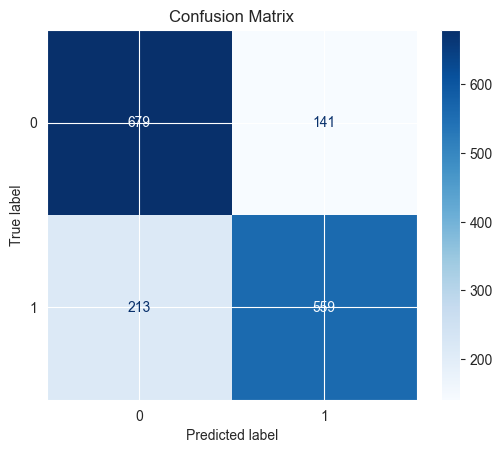

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Split your original training set into a new training and test set (80% train, 20% test)
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Preprocessing Pipeline (same as before)
numeric_features = ["startYear", "runtimeMinutes", "numVotes"]
categorical_features = ["director_id", "writer_id"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# Train Logistic Regression Model
model = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", SVC(kernel="linear", probability=True))
])

print("🔹 Training model on split training data...")
model.fit(X_train_split, y_train_split)

# Generate Predictions on the new test set
y_test_split_pred = model.predict(X_test_split)

# Calculate accuracy
accuracy = accuracy_score(y_test_split, y_test_split_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_test_split, y_test_split_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

plt.title('Confusion Matrix')
plt.show()
